In [11]:
import pandas as pd
import numpy as np
import nltk
import re
import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Count vectorization of text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **1. Data Collection ✍️**

In [12]:
dataset = pd.read_csv('MovieReviews_Augmented.csv')

In [13]:
pd.DataFrame(dataset)

,Unnamed: 0,text,Type
0,0,"Marlin, a nervous and neurotic clownfish is he...",positive
1,1,Yes you read that correctly.Finding Nemo had b...,positive
2,2,I didn't see this movie until it came out on D...,positive
3,3,Can Pixar and Disney miss with a film? Both To...,positive
4,4,"Never, and I mean, never, in my entire life, h...",positive
...,...,...,...
242,242,"Unlike Sharktale, where an equally admirable c...",neutral
243,243,Despite this movie basically being one giant p...,neutral
244,244,I distinctly remember my negative reaction to ...,neutral
245,245,A 2007 American animated film directed by Stev...,neutral


In [14]:
dataset.drop(columns=['Unnamed: 0'], inplace=True)

In [15]:
dataset['Type'].value_counts()

negative    95
positive    86
neutral     66
Name: Type, dtype: int64

In [16]:
dataset

,text,Type
0,"Marlin, a nervous and neurotic clownfish is he...",positive
1,Yes you read that correctly.Finding Nemo had b...,positive
2,I didn't see this movie until it came out on D...,positive
3,Can Pixar and Disney miss with a film? Both To...,positive
4,"Never, and I mean, never, in my entire life, h...",positive
...,...,...
242,"Unlike Sharktale, where an equally admirable c...",neutral
243,Despite this movie basically being one giant p...,neutral
244,I distinctly remember my negative reaction to ...,neutral
245,A 2007 American animated film directed by Stev...,neutral


In [17]:
len(dataset['Type'])

247

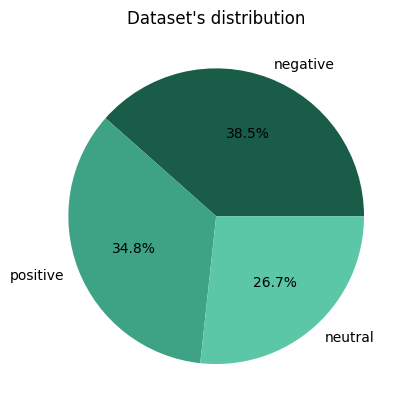

In [18]:
# Displays a Pie chart of the distribution of instances
x = dataset['Type'].value_counts()
plt.pie(x.values,
        labels = x.index,
        autopct='%1.1f%%', colors=['#195C48', '#3EA385', '#5BC7A7'])
plt.title("Dataset's distribution")
plt.show()

# **2.Data Preprocessing 🔍**

In [ ]:
def preprocess_tokens(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    # Remove special characters and punctuation using regular expression
    words = [re.sub(r'[^a-zA-Z0-9]', '', word) for word in words]  # Removes numbers and special characters
    without_stop_words = [w for w in words if not w.lower() in stop_words]
    stemming = SnowballStemmer('english')
    stemmed_words = [stemming.stem(w) for w in without_stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    return lemmatized_words

def preprocess_text(text):
    clean_sentence = preprocess_tokens(text)
    return ' '.join(clean_sentence)

In [ ]:
#dataset['text'] = dataset['text'].apply(Preprocessing_data)
dataset['processed_tokens'] = dataset['text'].apply(preprocess_tokens)
dataset['processed_text'] = dataset['text'].apply(preprocess_text)


In [ ]:
dataset

,text,Type,processed_tokens,processed_text
0,"Marlin, a nervous and neurotic clownfish is he...",positive,"[marlin, , nervous, neurot, clownfish, heavili...",marlin nervous neurot clownfish heavili overp...
1,Yes you read that correctly.Finding Nemo had b...,positive,"[yes, read, correctlyfind, nemo, brilliant, , ...",yes read correctlyfind nemo brilliant breatht...
2,I didn't see this movie until it came out on D...,positive,"[nt, see, movi, came, dvd, , famili, nt, go, m...",nt see movi came dvd famili nt go movi often ...
3,Can Pixar and Disney miss with a film? Both To...,positive,"[pixar, disney, miss, film, , toy, stori, , bu...",pixar disney miss film toy stori bug life m...
4,"Never, and I mean, never, in my entire life, h...",positive,"[never, , mean, , never, , entir, life, , movi...",never mean never entir life movi effect wa...
...,...,...,...,...
242,"Unlike Sharktale, where an equally admirable c...",neutral,"[unlik, sharktal, , equal, admir, coupl, combi...",unlik sharktal equal admir coupl combin voice...
243,Despite this movie basically being one giant p...,neutral,"[despit, movi, basic, one, giant, pun, good, m...",despit movi basic one giant pun good messag s...
244,I distinctly remember my negative reaction to ...,neutral,"[distinct, rememb, negat, reaction, trailer, ,...",distinct rememb negat reaction trailer never ...
245,A 2007 American animated film directed by Stev...,neutral,"[2007, american, anim, film, direct, steve, hi...",2007 american anim film direct steve hickner s...


# **3.Feature Extraction 📊**

 **3.1 Bag Of Words Feature Extraction**

In [ ]:
# BOW Feature Extraction
cv = CountVectorizer()
cv_features = cv.fit_transform(dataset['processed_text'])

In [ ]:
dataframeBOW = pd.DataFrame(cv_features.toarray(), columns = cv.get_feature_names_out())
# Concatenate BOW features with original DataFrame
dataset_bow = pd.concat([dataset.reset_index(drop=True), dataframeBOW], axis=1)
#dataframeBOW.head(214)
print(dataset_bow.shape)
dataset_bow.head()

(247, 2803)


,text,Type,processed_tokens,processed_text,numRepresentaion_text,00,10,100,1000,1010,...,yet,york,young,younger,youself,youwant,yr,zellweg,zellwegg,zoo
0,"Marlin, a nervous and neurotic clownfish is he...",positive,"[marlin, , nervous, neurot, clownfish, heavili...",marlin nervous neurot clownfish heavili overp...,"[0.021987193339579814, 0.041916058514569254, -...",0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,Yes you read that correctly.Finding Nemo had b...,positive,"[yes, read, correctlyfind, nemo, brilliant, , ...",yes read correctlyfind nemo brilliant breatht...,"[0.10620351938100961, 0.019786541278545674, 0....",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,I didn't see this movie until it came out on D...,positive,"[nt, see, movi, came, dvd, , famili, nt, go, m...",nt see movi came dvd famili nt go movi often ...,"[0.025377030806107953, 0.04039278897372159, -3...",0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Can Pixar and Disney miss with a film? Both To...,positive,"[pixar, disney, miss, film, , toy, stori, , bu...",pixar disney miss film toy stori bug life m...,"[-0.004174537265423647, 0.05846041256619483, -...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Never, and I mean, never, in my entire life, h...",positive,"[never, , mean, , never, , entir, life, , movi...",never mean never entir life movi effect wa...,"[0.014766492341694078, 0.020658994975842927, 0...",0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Splitting the dataset into training and testing sets (for BoW represntation)
from sklearn.model_selection import train_test_split
X_trainBoW, X_testBoW, y_trainBoW, y_testBoW = train_test_split(dataset_bow.drop(columns=['Type', 'text', 'processed_text','processed_tokens']), dataset_bow['Type'], test_size=0.2, random_state=42)


In [ ]:
X_trainBoW

,00,10,100,1000,1010,103,11,110,12,12step,...,yet,york,young,younger,youself,youwant,yr,zellweg,zellwegg,zoo
154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_trainBoW

154    negative
211     neutral
118    negative
195     neutral
240     neutral
         ...   
106    negative
14     positive
92     negative
179    negative
102    negative
Name: Type, Length: 197, dtype: object

**3.2 Word Embedding Feature Extraction**

In [ ]:
import gensim.downloader as api
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def sent_vec(sent):
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)
    # print(wv_res)
    ctr = 1
    for w in sent:
        if w in wv:
            ctr += 1
            wv_res += wv[w]
    wv_res = wv_res/ctr
    return wv_res

In [ ]:
dataset['numRepresentaion_text'] = dataset['processed_tokens'].apply(sent_vec)
print(dataset['numRepresentaion_text'])

0      [0.021987193339579814, 0.041916058514569254, -...
1      [0.10620351938100961, 0.019786541278545674, 0....
2      [0.025377030806107953, 0.04039278897372159, -3...
3      [-0.004174537265423647, 0.05846041256619483, -...
4      [0.014766492341694078, 0.020658994975842927, 0...
                             ...                        
242    [0.04058183942522321, 0.016424151829310826, -0...
243    [-0.012556243361088267, 0.04565670615748355, -...
244    [0.04538568460716391, 0.007087995421211675, 0....
245    [-0.06113448797487745, 0.016720388449874578, -...
246    [-0.05221761067708333, 0.0670916239420573, -0....
Name: numRepresentaion_text, Length: 247, dtype: object


# شرح
Let's say we have a Word2Vec model trained on a large corpus of text, and each word is represented by a 5-dimensional vector. Here's a hypothetical example of what the values in each dimension (dim) might represent:

dim_1: This dimension might represent the concept of "positive/negative sentiment". Words with positive connotations might have higher values in this dimension, while words with negative connotations might have lower values.

dim_2: This dimension might capture the concept of "size". Words representing large objects or concepts might have higher values in this dimension, while words representing small objects or concepts might have lower values.

dim_3: This dimension could represent "motion". Words related to movement or action might have higher values, while stationary objects or concepts might have lower values.

dim_4: This dimension might encode "color". Words related to colors might have higher values in this dimension, with different values corresponding to different hues or shades.

dim_5: This dimension might represent "emotion". Words associated with emotions such as happiness, sadness, anger, etc., might have different values in this dimension, allowing the model to capture emotional nuances in text.

These are just hypothetical examples, and the actual meanings of the dimensions would depend on the specifics of the Word2Vec model and the corpus it was trained on. The values in each dimension help encode different aspects of the semantic content of words and sentences, allowing the model to capture the richness and complexity of language.

In [ ]:
# Create a DataFrame from the Word2Vec representations
word2vec_df = pd.DataFrame(dataset['numRepresentaion_text'].tolist(), columns=[f'dim_{i+1}' for i in range(wv.vector_size)])
# print the Word2Vector representaion
# vector representation of each instance in the dataset
word2vec_df

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,...,dim_291,dim_292,dim_293,dim_294,dim_295,dim_296,dim_297,dim_298,dim_299,dim_300
0,0.021987,0.041916,-0.016586,0.085820,-0.065976,0.008457,0.056853,-0.026687,0.070104,0.043883,...,-0.047461,0.027849,-0.092177,-0.039959,-0.047207,-0.021066,-0.004782,-0.036736,0.013206,0.019992
1,0.106204,0.019787,0.031590,0.099013,-0.003648,0.011355,0.032677,-0.053042,0.045887,0.090079,...,-0.070000,0.036090,-0.106080,-0.009112,-0.046499,-0.065820,0.015334,-0.138402,-0.028106,-0.029681
2,0.025377,0.040393,-0.000037,0.107107,-0.065214,0.012517,0.053658,-0.035617,0.076000,0.053737,...,-0.010540,0.044914,-0.071556,0.008072,-0.009811,-0.072570,-0.012457,-0.047546,0.003528,0.011179
3,-0.004175,0.058460,-0.032179,0.085866,-0.065845,0.010026,-0.011768,-0.041714,0.043950,0.070518,...,-0.019458,0.019945,-0.087050,-0.025963,-0.022505,-0.042329,-0.005443,-0.024278,0.015109,-0.009448
4,0.014766,0.020659,0.009212,0.094623,-0.051746,0.011508,0.047893,-0.064530,0.061260,0.082185,...,-0.045926,0.072369,-0.094180,0.023540,-0.046439,-0.050676,-0.001250,-0.073860,0.009679,-0.009574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,0.040582,0.016424,-0.019122,0.100183,-0.049634,0.027175,0.062752,-0.046555,0.033782,0.049531,...,-0.062586,0.062069,-0.050428,0.004638,-0.040313,-0.025257,0.026190,-0.035687,-0.041177,-0.011415
243,-0.012556,0.045657,-0.019181,0.073174,-0.061296,0.018421,0.111382,-0.046855,0.056736,0.071047,...,-0.060415,0.080443,-0.079718,0.034888,-0.049461,-0.030674,0.011357,-0.062607,0.009393,-0.031571
244,0.045386,0.007088,0.021702,0.082627,-0.052728,0.021088,0.044414,-0.083984,0.080598,0.050051,...,-0.066081,0.066584,-0.084943,0.034555,-0.037379,-0.070727,-0.014479,-0.079681,0.007022,-0.031085
245,-0.061134,0.016720,-0.029506,0.111110,-0.040954,0.011572,-0.010731,-0.042553,0.035241,0.027510,...,-0.044027,0.056321,-0.070989,-0.015743,-0.040002,-0.037112,-0.015804,-0.011636,0.015037,0.032738


In [ ]:
# Concatenate the original dataset with the Word2Vec DataFrame
word2vec_dataset = pd.concat([dataset, word2vec_df], axis=1)

# Print the shape and the first few rows of the resulting DataFrame
print("Shape of the Word2Vec DataFrame:", word2vec_dataset.shape)
print("First few rows of the Word2Vec DataFrame:")
word2vec_dataset.head(247)

Shape of the Word2Vec DataFrame: (247, 305)
First few rows of the Word2Vec DataFrame:


,text,Type,processed_tokens,processed_text,numRepresentaion_text,dim_1,dim_2,dim_3,dim_4,dim_5,...,dim_291,dim_292,dim_293,dim_294,dim_295,dim_296,dim_297,dim_298,dim_299,dim_300
0,"Marlin, a nervous and neurotic clownfish is he...",positive,"[marlin, , nervous, neurot, clownfish, heavili...",marlin nervous neurot clownfish heavili overp...,"[0.021987193339579814, 0.041916058514569254, -...",0.021987,0.041916,-0.016586,0.085820,-0.065976,...,-0.047461,0.027849,-0.092177,-0.039959,-0.047207,-0.021066,-0.004782,-0.036736,0.013206,0.019992
1,Yes you read that correctly.Finding Nemo had b...,positive,"[yes, read, correctlyfind, nemo, brilliant, , ...",yes read correctlyfind nemo brilliant breatht...,"[0.10620351938100961, 0.019786541278545674, 0....",0.106204,0.019787,0.031590,0.099013,-0.003648,...,-0.070000,0.036090,-0.106080,-0.009112,-0.046499,-0.065820,0.015334,-0.138402,-0.028106,-0.029681
2,I didn't see this movie until it came out on D...,positive,"[nt, see, movi, came, dvd, , famili, nt, go, m...",nt see movi came dvd famili nt go movi often ...,"[0.025377030806107953, 0.04039278897372159, -3...",0.025377,0.040393,-0.000037,0.107107,-0.065214,...,-0.010540,0.044914,-0.071556,0.008072,-0.009811,-0.072570,-0.012457,-0.047546,0.003528,0.011179
3,Can Pixar and Disney miss with a film? Both To...,positive,"[pixar, disney, miss, film, , toy, stori, , bu...",pixar disney miss film toy stori bug life m...,"[-0.004174537265423647, 0.05846041256619483, -...",-0.004175,0.058460,-0.032179,0.085866,-0.065845,...,-0.019458,0.019945,-0.087050,-0.025963,-0.022505,-0.042329,-0.005443,-0.024278,0.015109,-0.009448
4,"Never, and I mean, never, in my entire life, h...",positive,"[never, , mean, , never, , entir, life, , movi...",never mean never entir life movi effect wa...,"[0.014766492341694078, 0.020658994975842927, 0...",0.014766,0.020659,0.009212,0.094623,-0.051746,...,-0.045926,0.072369,-0.094180,0.023540,-0.046439,-0.050676,-0.001250,-0.073860,0.009679,-0.009574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,"Unlike Sharktale, where an equally admirable c...",neutral,"[unlik, sharktal, , equal, admir, coupl, combi...",unlik sharktal equal admir coupl combin voice...,"[0.04058183942522321, 0.016424151829310826, -0...",0.040582,0.016424,-0.019122,0.100183,-0.049634,...,-0.062586,0.062069,-0.050428,0.004638,-0.040313,-0.025257,0.026190,-0.035687,-0.041177,-0.011415
243,Despite this movie basically being one giant p...,neutral,"[despit, movi, basic, one, giant, pun, good, m...",despit movi basic one giant pun good messag s...,"[-0.012556243361088267, 0.04565670615748355, -...",-0.012556,0.045657,-0.019181,0.073174,-0.061296,...,-0.060415,0.080443,-0.079718,0.034888,-0.049461,-0.030674,0.011357,-0.062607,0.009393,-0.031571
244,I distinctly remember my negative reaction to ...,neutral,"[distinct, rememb, negat, reaction, trailer, ,...",distinct rememb negat reaction trailer never ...,"[0.04538568460716391, 0.007087995421211675, 0....",0.045386,0.007088,0.021702,0.082627,-0.052728,...,-0.066081,0.066584,-0.084943,0.034555,-0.037379,-0.070727,-0.014479,-0.079681,0.007022,-0.031085
245,A 2007 American animated film directed by Stev...,neutral,"[2007, american, anim, film, direct, steve, hi...",2007 american anim film direct steve hickner s...,"[-0.06113448797487745, 0.016720388449874578, -...",-0.061134,0.016720,-0.029506,0.111110,-0.040954,...,-0.044027,0.056321,-0.070989,-0.015743,-0.040002,-0.037112,-0.015804,-0.011636,0.015037,0.032738


here two different methods for splitting data

first: from here https://thinkingneuron.com/how-to-classify-text-using-word2vec/
it says this will be helpful when training naive bayes model?

second is from reem code:)

In [ ]:
# Splitting the dataset into training and testing sets  (for W2V represntation)
from sklearn.model_selection import train_test_split
X_trainW2V, X_testW2V, y_trainW2V, y_testW2V = train_test_split(word2vec_dataset.drop(columns=['Type', 'text', 'processed_text','processed_tokens','numRepresentaion_text']), word2vec_dataset['Type'], test_size=0.2, random_state=42)

In [ ]:
X_trainW2V

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,...,dim_291,dim_292,dim_293,dim_294,dim_295,dim_296,dim_297,dim_298,dim_299,dim_300
154,0.001295,0.000044,0.060471,0.077863,-0.091413,0.019006,0.015180,-0.051671,0.083027,0.016576,...,0.006027,0.121966,-0.086545,-0.003981,-0.123605,-0.074411,-0.057565,-0.054677,0.055908,0.031980
211,-0.003346,0.030221,-0.019496,0.132956,-0.050169,0.068290,0.053864,-0.048588,0.041766,0.091848,...,-0.015121,0.089673,-0.078199,-0.010692,-0.062568,-0.078072,0.018679,-0.009376,0.028018,-0.025947
118,0.047405,0.070915,0.034925,0.104571,-0.027247,-0.016053,0.062447,-0.057061,0.079541,0.021420,...,-0.036939,0.063404,-0.120594,-0.030648,-0.073029,-0.018643,-0.025921,-0.008776,-0.028801,-0.014706
195,-0.063281,0.062378,0.012280,0.080371,-0.116895,0.056592,0.111377,-0.125429,0.047168,-0.014893,...,-0.066943,0.128809,-0.022388,0.048511,-0.067969,-0.052686,0.009619,-0.022833,-0.070337,0.067615
240,0.002248,0.073145,-0.001370,0.084850,-0.059038,0.019517,0.032857,-0.040842,0.017479,0.069510,...,0.002414,0.043491,-0.039843,-0.009046,-0.043222,-0.074652,-0.035287,-0.023236,0.006372,0.031360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.022235,0.054006,0.029562,0.091698,-0.053750,0.041232,0.041134,-0.046962,0.083650,0.055636,...,-0.041238,0.055129,-0.084812,-0.023620,-0.060260,-0.082395,-0.017406,-0.049720,-0.030584,0.021929
14,0.026169,0.042719,-0.002772,0.078675,-0.058960,0.000006,0.026415,-0.043023,0.050217,0.060461,...,-0.024579,0.041458,-0.102533,-0.036347,-0.021043,-0.041222,-0.014152,-0.039143,0.020832,0.009901
92,0.020297,0.025126,0.004477,0.083858,-0.064150,0.011013,0.058213,-0.022618,0.041115,0.022673,...,-0.015009,0.084731,-0.098328,-0.014880,-0.076754,-0.061696,-0.057057,-0.058547,0.007639,0.006549
179,0.027726,0.062478,0.011100,0.101383,-0.047858,-0.011015,0.050531,-0.050698,0.014215,0.043958,...,-0.023503,0.118903,-0.078867,0.039718,-0.096660,-0.022731,0.057473,-0.016010,0.002237,-0.003476


In [ ]:
y_trainW2V

154    negative
211     neutral
118    negative
195     neutral
240     neutral
         ...   
106    negative
14     positive
92     negative
179    negative
102    negative
Name: Type, Length: 197, dtype: object

**3.3 TF-IDF Feature Extraction**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))

#transformed features
tv_features =tv.fit_transform(dataset['processed_text'])

# Create a DataFrame from the transformed features
tv_df = pd.DataFrame(tv_features.toarray(), columns=tv.get_feature_names_out())

print('tv_features:',tv_features.shape)
tv_df

tv_features: (247, 24284)


,00,00 boy,00 boy band,10 10 imdb,10 anim,10 anim featur,10 believ,10 believ could,10 imdb,10 imdb star,...,youself nt listen,youwant,youwant say,youwant say live,yr,yr old,yr old crush,zellwegg,zellwegg warm,zellwegg warm endear
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.081111,0.081111,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Concatenate the original dataset with the Tf_IDF DataFrame
tf_idf_dataset = pd.concat([dataset, tv_df], axis=1)

# Print the shape and the first few rows of the resulting DataFrame
print("Shape of the Tf_IDF DataFrame:", tf_idf_dataset.shape)
print("First few rows of the Tf_IDF DataFrame:")
tf_idf_dataset.head()

Shape of the Tf_IDF DataFrame: (247, 24289)
First few rows of the Tf_IDF DataFrame:


,text,Type,processed_tokens,processed_text,numRepresentaion_text,00,00 boy,00 boy band,10 10 imdb,10 anim,...,youself nt listen,youwant,youwant say,youwant say live,yr,yr old,yr old crush,zellwegg,zellwegg warm,zellwegg warm endear
0,"Marlin, a nervous and neurotic clownfish is he...",positive,"[marlin, , nervous, neurot, clownfish, heavili...",marlin nervous neurot clownfish heavili overp...,"[0.021987193339579814, 0.041916058514569254, -...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Yes you read that correctly.Finding Nemo had b...,positive,"[yes, read, correctlyfind, nemo, brilliant, , ...",yes read correctlyfind nemo brilliant breatht...,"[0.10620351938100961, 0.019786541278545674, 0....",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,I didn't see this movie until it came out on D...,positive,"[nt, see, movi, came, dvd, , famili, nt, go, m...",nt see movi came dvd famili nt go movi often ...,"[0.025377030806107953, 0.04039278897372159, -3...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Can Pixar and Disney miss with a film? Both To...,positive,"[pixar, disney, miss, film, , toy, stori, , bu...",pixar disney miss film toy stori bug life m...,"[-0.004174537265423647, 0.05846041256619483, -...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Never, and I mean, never, in my entire life, h...",positive,"[never, , mean, , never, , entir, life, , movi...",never mean never entir life movi effect wa...,"[0.014766492341694078, 0.020658994975842927, 0...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Splitting the dataset into training and testing sets  (for TF-IDF represntation)
from sklearn.model_selection import train_test_split
X_trainTF_IDF, X_testTF_IDF, y_trainTF_IDF, y_testTF_IDF = train_test_split(tf_idf_dataset.drop(columns=['Type', 'text', 'processed_text','processed_tokens','numRepresentaion_text']), tf_idf_dataset['Type'], test_size=0.2, random_state=42)

In [ ]:
X_trainTF_IDF

,00,00 boy,00 boy band,10 10 imdb,10 anim,10 anim featur,10 believ,10 believ could,10 imdb,10 imdb star,...,youself nt listen,youwant,youwant say,youwant say live,yr,yr old,yr old crush,zellwegg,zellwegg warm,zellwegg warm endear
154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.118678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_trainTF_IDF

154    negative
211     neutral
118    negative
195     neutral
240     neutral
         ...   
106    negative
14     positive
92     negative
179    negative
102    negative
Name: Type, Length: 197, dtype: object

# normalization for Word2vector features

In [ ]:

from sklearn.preprocessing import  MinMaxScaler

# On this data Min Max Normalization is used because we need to fit Naive Bayes, because Negative values can not be porecessed py navie bayes
PredictorScaler=MinMaxScaler()

# Storing the fit object for later reference
PredictorScalerFitTrainW2V=PredictorScaler.fit(X_trainW2V)

# Generating the standardized values of X_train
X_trainW2V=PredictorScalerFitTrainW2V.transform(X_trainW2V)

# Storing the fit object for later reference
PredictorScalerFitTestW2V = PredictorScaler.fit(X_testW2V)

# Generating the standardized values of X_test
X_testW2V = PredictorScalerFitTestW2V.transform(X_testW2V)

# normalization for Bag of Words features

In [ ]:

# Storing the fit object for later reference
PredictorScalerFitTrainBoW=PredictorScaler.fit(X_trainBoW)

# Generating the standardized values of X_train
X_trainBoW=PredictorScalerFitTrainBoW.transform(X_trainBoW)

# Storing the fit object for later reference
PredictorScalerFitTestBow = PredictorScaler.fit(X_testBoW)

# Generating the standardized values of X_test
X_testBoW = PredictorScalerFitTestBow.transform(X_testBoW)

# normalization for TF-IDF features

In [ ]:
# Storing the fit object for later reference
PredictorScalerFitTrainTF_IDF=PredictorScaler.fit(X_trainTF_IDF)

# Generating the standardized values of X_train
X_trainTF_IDF=PredictorScalerFitTrainTF_IDF.transform(X_trainTF_IDF)

# Storing the fit object for later reference
PredictorScalerFitTestTF_IDF = PredictorScaler.fit(X_testTF_IDF)

# Generating the standardized values of X_test
X_testTF_IDF = PredictorScalerFitTestTF_IDF.transform(X_testTF_IDF)

# **4.Model Selection 💡**

# Naive Bayes for W2V

In [ ]:

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# MultinomialNB is used in multi-class classification
MNP = MultinomialNB()

# Printing all the parameters of Naive Bayes
print(MNP.get_params)



<bound method BaseEstimator.get_params of MultinomialNB()>


In [ ]:
NB=MNP.fit(X_trainW2V,y_trainW2V)

In [ ]:
predictionOfW2V=NB.predict(X_testW2V)
predictionOfW2V

array(['positive', 'positive', 'neutral', 'negative', 'negative',
       'negative', 'negative', 'negative', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'negative', 'neutral', 'neutral',
       'positive', 'positive', 'negative', 'negative', 'negative',
       'positive', 'negative', 'positive', 'negative', 'negative',
       'negative', 'positive', 'negative', 'negative', 'neutral',
       'negative', 'negative', 'positive', 'negative', 'positive',
       'negative', 'neutral', 'negative', 'positive', 'negative',
       'negative', 'positive', 'negative', 'positive', 'negative',
       'negative', 'negative', 'negative', 'neutral'], dtype='<U8')

In [ ]:
y_testW2V

33     positive
6      positive
181     neutral
86     negative
155    negative
178    negative
194     neutral
104    negative
9      positive
234     neutral
231     neutral
213     neutral
237     neutral
173    negative
66     positive
222     neutral
219     neutral
15     positive
182     neutral
24     positive
120    negative
19     positive
112    negative
67     positive
221     neutral
156    negative
199     neutral
10     positive
30     positive
96     negative
235     neutral
242     neutral
117    negative
25     positive
244     neutral
18     positive
132    negative
198     neutral
55     positive
45     positive
216     neutral
109    negative
60     positive
183     neutral
16     positive
119    negative
68     positive
170    negative
38     positive
245     neutral
Name: Type, dtype: object

# Naive Bayes for BoW

In [ ]:
#fitting the svm for bag of words
mnb_bow=MNP.fit(X_trainBoW,y_trainBoW)
#Predicting the model for bag of words
predictionOfBoW =NB.predict(X_testBoW)
predictionOfBoW

array(['positive', 'negative', 'neutral', 'negative', 'negative',
       'negative', 'neutral', 'negative', 'positive', 'neutral',
       'neutral', 'neutral', 'neutral', 'negative', 'positive', 'neutral',
       'neutral', 'positive', 'neutral', 'positive', 'negative',
       'positive', 'negative', 'positive', 'neutral', 'negative',
       'negative', 'positive', 'positive', 'negative', 'neutral',
       'neutral', 'negative', 'positive', 'neutral', 'positive',
       'negative', 'neutral', 'positive', 'positive', 'neutral',
       'negative', 'positive', 'neutral', 'positive', 'negative',
       'positive', 'negative', 'positive', 'neutral'], dtype='<U8')

# Naive Bayes for TF-IDF

In [ ]:
#fitting the svm for bag of words
mnb_tf_idf=MNP.fit(X_trainTF_IDF,y_trainTF_IDF)
#Predicting the model for bag of words
predictionOfTF_IDF =NB.predict(X_testTF_IDF)
predictionOfTF_IDF

array(['negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative'],
      dtype='<U8')

# Multinomial Logistic Regression for W2V

In [ ]:
model2 = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model2.fit(X_trainW2V, y_trainW2V)
y_pred22 = model2.predict(X_testW2V)

# Multinomial Logistic Regression for Bag of Words (BOW)

In [ ]:

model1 = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model1.fit(X_trainBoW, y_trainBoW)
y_pred1 = model1.predict(X_testBoW)

# Multinomial Logistic Regression for TF-IDF

In [ ]:
model3 = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model3.fit(X_trainTF_IDF, y_trainTF_IDF)
y_pred3 = model3.predict(X_testTF_IDF)

# **5.Model Evaulation 📈**

# evaluation of Naive Bayes model traind on W2V features

In [ ]:
# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_testW2V, predictionOfW2V))
print(metrics.confusion_matrix(y_testW2V, predictionOfW2V))

# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_testW2V, predictionOfW2V, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))


              precision    recall  f1-score   support

    negative       0.52      1.00      0.68        14
     neutral       0.82      0.50      0.62        18
    positive       0.92      0.61      0.73        18

    accuracy                           0.68        50
   macro avg       0.75      0.70      0.68        50
weighted avg       0.77      0.68      0.68        50

[[14  0  0]
 [ 8  9  1]
 [ 5  2 11]]
Accuracy of the model on Testing Sample Data: 0.68


# evaluation of Naive Bayes model traind on Bag Of  Words features

In [ ]:
# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_testBoW, predictionOfBoW))
print(metrics.confusion_matrix(y_testBoW, predictionOfBoW))

# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_testBoW, predictionOfBoW, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))


              precision    recall  f1-score   support

    negative       0.88      1.00      0.93        14
     neutral       1.00      0.94      0.97        18
    positive       1.00      0.94      0.97        18

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50

[[14  0  0]
 [ 1 17  0]
 [ 1  0 17]]
Accuracy of the model on Testing Sample Data: 0.96


# evaluation of Naive Bayes model traind on TF_IDF features

In [ ]:
# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_testTF_IDF, predictionOfTF_IDF))
print(metrics.confusion_matrix(y_testTF_IDF, predictionOfTF_IDF))

# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_testTF_IDF, predictionOfTF_IDF, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

              precision    recall  f1-score   support

    negative       0.28      1.00      0.44        14
     neutral       0.00      0.00      0.00        18
    positive       0.00      0.00      0.00        18

    accuracy                           0.28        50
   macro avg       0.09      0.33      0.15        50
weighted avg       0.08      0.28      0.12        50

[[14  0  0]
 [18  0  0]
 [18  0  0]]
Accuracy of the model on Testing Sample Data: 0.12


# Evaluation of Multinomial Logistic Regression Trained On W2V

In [ ]:
acc2 = accuracy_score(y_testW2V, y_pred22)
print("Logistic Regression model accuracy (in %):", acc2*100)
print(classification_report
      (y_testW2V, model2.predict(X_testW2V)))

# Evaluation of Multinomial Logistic Regression Trained On Bag Of Words (BOW)

In [ ]:
acc1 = accuracy_score(y_testBoW, y_pred1)
print("Logistic Regression model accuracy (in %):", acc1*100)
from sklearn.metrics import classification_report
print(classification_report
      (y_testBoW, model1.predict(X_testBoW)))

# Evaluation of Multinomial Logistic Regression Trained On TF-IDF

In [ ]:
accTF_IDF = accuracy_score(y_testTF_IDF, y_pred3)
print("Logistic Regression model accuracy (in %):", accTF_IDF*100)
print(classification_report
      (y_testTF_IDF, model3.predict(X_testTF_IDF)))